# Imports

In [961]:
import loompy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import pickle
from scipy.spatial.distance import pdist
from fastcluster import linkage
import polo # 
from polo import optimal_leaf_ordering #from polo import polo
#Paper: http://bioinformatics.oxfordjournals.org/content/17/suppl_1/S22.long
from scipy.cluster import hierarchy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import LEBorm_functions as lb

%matplotlib notebook

# Data

In [2]:
file_name = '/home/lars/storage/Documents/Cortex_FISH/CountsV1-1.loom'

def loompy2data(filename, cutoff_low, cutoff_high, molecules_low):
    """
    Loom file to Panda's dataframe. Perform size and count selection on cells
    Input:
    `filename`(str): Name and path tot the Loom file
    `cutoff_low`(flt): Minimal cell size (in number of pixels, square um = (np.sqrt(pixels)*0.065)**2
    `cutoff_high`(flt): Max cell size (in number of pixels, square um = (np.sqrt(pixels)*0.065)**2
    `molecules_low`(int): Minimal number of molecules
    Returns:
    Panda's dataframe with cells that passed the criteria. df has cell label as column name. 
    Some gene names are corrected
    Metadata is discarded. 
    
    """
    #Read loom file and import to Pandas df
    ds = loompy.connect(filename)
    df=pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['genes']).astype(int)
    
    #Filter cell size
    for i, j in enumerate(ds.col_attrs['CellID']):
        if ds.col_attrs['CellArea'][i] < cutoff_low or ds.col_attrs['CellArea'][i] > cutoff_high:
            del df[j]
    
    #Filter total molecule count
    for i, j in enumerate(ds.col_attrs['CellID']):
        try: #not all 'CellID' are still present
            if df[j].sum() < molecules_low:
                del df[j]
        except Exception:
            pass
        
    #Filter bad hybridiztion4 (out of focus imaging) and repeat Tbr1
    bad_data = ['Hybridization4_Cnr1', 'Hybridization4_Plp1', 'Hybridization4_Vtn', 'Hybridization11_Tbr1']
    for i in bad_data:
        df.drop(i, inplace=True)
     
    #Change incorrect names Tmem6-->Tmem2 and Kcnip-->Kcnip2
    df= df.rename({'Hybridization11_Tmem6': 'Hybridization11_Tmem2', 'Hybridization12_Kcnip': 'Hybridization12_Kcnip2'})
    
    print('Selected cells with  {}>size<{} and a minimum molecule count of {} molecules'.format(cutoff_low, cutoff_high, molecules_low))
    print('Change incorrect names Tmem6-->Tmem2 and Kcnip-->2')
    return df

    
df_fish = loompy2data(file_name,2000, 60000, 20)
df_fish.shape

Selected cells with  2000>size<60000 and a minimum molecule count of 20 molecules
Change incorrect names Tmem6-->Tmem2 and Kcnip-->2


(35, 6036)

In [3]:
gene_sort = ['Gad2', 'Slc32a1', 'Crhbp', 'Kcnip2', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh',             
             'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 
             'Aldoc', 'Gfap', 'Serpinf1', 'Mfge8', 
             'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem2',  'Ctps',  'Klk6', 'Anln',   
             'Mrc1', 'Hexb', 
             'Ttr', 
             'Foxj1', 
             'Vtn', 'Flt1', 'Apln', 'Acta2',  'Lum'] 

gene_sort_wrong = ['Gad2', 'Slc32a1', 'Crhbp', 'Kcnip', 'Cnr1', 'Vip', 'Cpne5', 'Pthlh', 'Crh', 
             'Tbr1', 'Lamp5', 'Rorb', 'Syt6', 
             'Aldoc', 'Gfap', 'Serpinf1', 'Mfge8', 
             'Sox10', 'Plp1', 'Pdgfra', 'Bmp4', 'Itpr2', 'Tmem6',  'Ctps',  'Klk6', 'Anln',   
             'Mrc1', 'Hexb', 
             'Ttr', 
             'Foxj1', 
             'Vtn', 'Flt1', 'Apln', 'Acta2',  'Lum'] 


gene_sort_fish = ['Hybridization2_Gad2', 'Hybridization12_Slc32a1', 'Hybridization10_Crhbp', 'Hybridization12_Kcnip2', 'Hybridization13_Cnr1', 'Hybridization6_Vip', 'Hybridization5_Cpne5', 'Hybridization8_Pthlh',  'Hybridization10_Crh', 
'Hybridization1_Tbr1', 'Hybridization9_Lamp5', 'Hybridization7_Rorb', 'Hybridization11_Syt6',
'Hybridization1_Aldoc', 'Hybridization2_Gfap', 'Hybridization8_Serpinf1', 'Hybridization3_Mfge8',
 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization8_Pdgfra', 'Hybridization6_Bmp4','Hybridization6_Itpr2','Hybridization11_Tmem2', 'Hybridization7_Ctps','Hybridization5_Klk6','Hybridization9_Anln',
 'Hybridization3_Mrc1','Hybridization3_Hexb', 
 'Hybridization13_Ttr',
 'Hybridization1_Foxj1',
 'Hybridization12_Vtn',
 'Hybridization2_Flt1',
 'Hybridization10_Apln',
 'Hybridization5_Acta2',
 'Hybridization9_Lum']


#Make conversion dictionary with gene names and corresponding HybridizationX_geneY names

gene_name_conversion = {}

for i in gene_sort:
    for j in df_fish.index:
        if j.endswith(i):
            gene_name_conversion[j] =i
            
gene_name_conversion_reverse = dict((v,k) for k,v in gene_name_conversion.items())
            

In [4]:
#Open object properties
obj_prop = pickle.load(open("ObjProp_dict.pkl", 'rb'))

#Load cell ID and XY coordinates into a list
coord_list = []
for i in obj_prop:
    coord_list.append([i, obj_prop[i]['obj_centroid'][0], obj_prop[i]['obj_centroid'][1]])
    
#Place cell ID and X and Y coordinates into dataframe
coord_df = pd.DataFrame(coord_list, columns=['Cell_ID', 'X', 'Y']).set_index('Cell_ID').T
coord_df = coord_df.loc[:,df_fish.columns]

In [5]:
df_fish = df_fish.loc[gene_sort_fish,:]

#Transform data
X = df_fish.values.astype(np.float64)
    #Sqrt normalize
X_sqrt = np.sqrt(X)
    #Mean normalize
X_norm = X.sum(0).mean() * (X/X.sum(0))
    #Log transform
X_log = np.log2(X_norm+1)

    #Build dataframes of normalized and log transformed data
df_fish_sqrt = pd.DataFrame(data=X_sqrt, columns=df_fish.columns, index=df_fish.index)
df_fish_norm = pd.DataFrame(data=X_norm, columns=df_fish.columns, index=df_fish.index)
df_fish_log = pd.DataFrame(data=X_log, columns=df_fish.columns, index=df_fish.index)

#Devide by size
area_df_fish = np.array([(np.sqrt(obj_prop[c]['obj_area'])*0.065)**2 for c in df_fish.columns])
X_size = X/area_df_fish
    #Sqrt normalize
X_size_sqrt = np.sqrt(X_size)
    #Mean normalize
X_size_norm = X_size.sum(0).mean() * (X_size/X_size.sum(0))
    #Log transform
X_size_log = np.log2(X_size_norm+1)

    #Build dataframes of normalized and log transformed data
df_fish_size_sqrt = pd.DataFrame(data=X_size_sqrt, columns=df_fish.columns, index=df_fish.index)
df_fish_size_norm = pd.DataFrame(data=X_size_norm, columns=df_fish.columns, index=df_fish.index)
df_fish_size_log = pd.DataFrame(data=X_size_log, columns=df_fish.columns, index=df_fish.index)


#Calculate the fold change dataframe
df_fish_fc = df_fish.loc[gene_sort_fish,:]
mean_expression_for_fc =  df_fish.loc[gene_sort_fish,:].T.mean()
df_fish_fc = df_fish_fc.divide(mean_expression_for_fc, axis='rows')

X_fc = df_fish_fc.values

# Test dataset

In [6]:
olig_id = pickle.load(open("oligodendrocytes.p", 'rb'))
df_olig = df_fish_size_sqrt.loc[:,olig_id]

In [7]:
df_olig.head(5)

994      2872      5434      4234      2913  \
Hybridization2_Gad2      0.199621  0.117908  0.202330  0.210055  0.204283   
Hybridization12_Slc32a1  0.000000  0.000000  0.116815  0.105027  0.000000   
Hybridization10_Crhbp    0.115251  0.117908  0.286138  0.000000  0.166796   
Hybridization12_Kcnip2   0.000000  0.166747  0.165202  0.000000  0.000000   
Hybridization13_Cnr1     0.199621  0.204223  0.233630  0.148531  0.166796   

                             3230      2288      4495      4123      5302  \
Hybridization2_Gad2      0.215823  0.185290  0.568956  0.696480  0.233374   
Hybridization12_Slc32a1  0.000000  0.000000  0.000000  0.372284  0.000000   
Hybridization10_Crhbp    0.000000  0.000000  0.000000  0.322407  0.000000   
Hybridization12_Kcnip2   0.000000  0.106977  0.164243  0.372284  0.000000   
Hybridization13_Cnr1     0.000000  0.354803  0.284478  0.263245  0.104368   

                          ...         6581      3075      1024      2314  \
Hybridization2_Gad2       ...     0.275208  0.433273  0.409246  0.377686   
Hybridization12_Slc32a1   ...     0.000000  0.000000  0.000000  0.000000   
Hybridization10_Crhbp     ...     0.000000  0.000000  0.105667  0.000000   
Hybridization12_Kcnip2    ...     0.275208  0.000000  0.105667  0.000000   
Hybridization13_Cnr1      ...     0.000000  0.000000  0.236278  0.000000   

                             1101      2808      3251      2757      1228  \
Hybridization2_Gad2      0.349566  0.000000  0.124412  0.157064  0.224959   
Hybridization12_Slc32a1  0.180515  0.105712  0.000000  0.222121  0.000000   
Hybridization10_Crhbp    0.180515  0.105712  0.000000  0.000000  0.000000   
Hybridization12_Kcnip2   0.156331  0.183098  0.000000  0.157064  0.000000   
Hybridization13_Cnr1     0.156331  0.211424  0.087972  0.192363  0.000000   

                            1234  
Hybridization2_Gad2      0.36652  
Hybridization12_Slc32a1  0.00000  
Hybridization10_Crhbp    0.00000  
Hybridization12_Kcnip2   0.00000  
Hybridization13_Cnr1     0.00000  

[5 rows x 848 columns]

In [8]:
def cluster_binarity(df, labels, cluster_of_interest, cutoff_expression, cutoff_percentage):
    """
    Calculates the percentage of cells, of a given cluster_of_interest in a df, 
    that have an expression above the cutoff_expression. It returns a pandas 
    Series with the percentages and it returns the names of the genes that have
    a percentage higher than the cutoff_percentage.
    Input:
    `df`(pandas dataframe): df of the cells that were clusterd.
    `labels`(numpy array): Cluster labels of the clustering, in same order as df.
    `cluster_of_interest`(int): Cluster of interest from the labels.
    `cutoff_expression`(float): used to make a binarization and is the same for
        all genes. Data normalization is very important!
    `cutoff_percentage`(float): Percentage of cells that need to be 'positive'
        in the cluster. 
    Returns:
    *Pandas series with the percentages for all genes
    *List of names of genes with a percentage higher than the cutoff_percentage
    
    """
    filt = labels == cluster_of_interest
    df = df.loc[:,filt]
    
    #Calculate percentage of cells that are above the cutoff
        #Percentage of cells that are above cutoff_expression
    positive = (df[df>cutoff_expression].T.count() / df.shape[1]) * 100
        #Genes that are considered positive above the cutoff_percentage
    positive_genes = [positive.index[i] for i,n in enumerate(positive) if n>cutoff_percentage]
    return positive, positive_genes

In [26]:
def gini(array):
    #Function from:
    #https://github.com/oliviaguest/gini/blob/master/gini.py
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

Order of clusters: [0, 1]


<IPython.core.display.Javascript object>


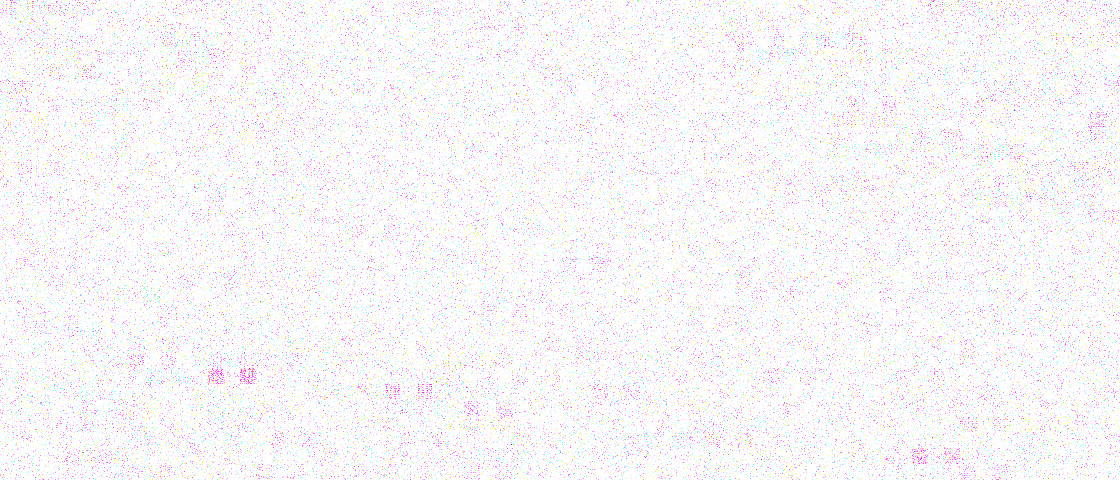

(35, 848)
848
['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization7_Sox10', 'Hybridization13_Plp1']




In [44]:
split = AgglomerativeClustering(n_clusters=2).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[1])
    print('\n')

Order of clusters: [0, 1, 2]


<IPython.core.display.Javascript object>


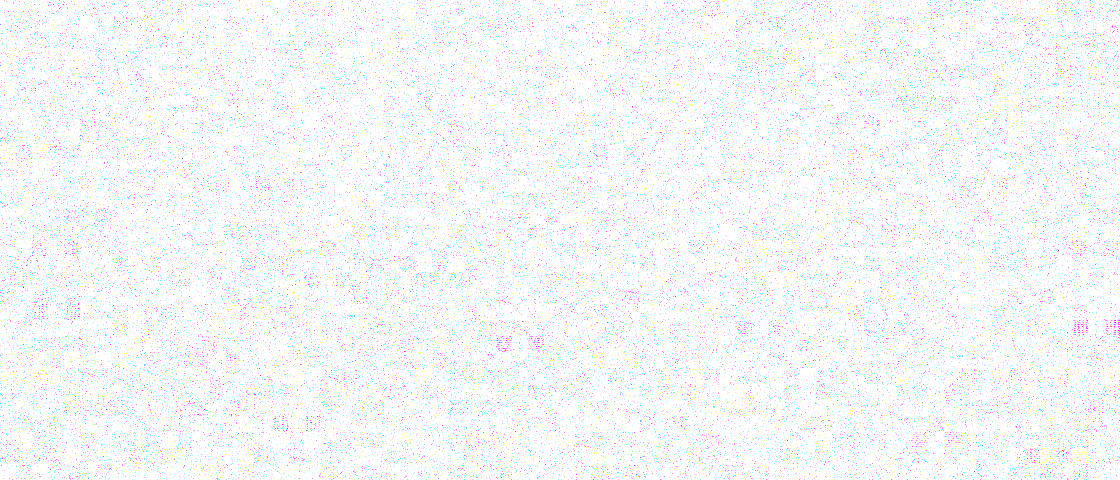

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']




In [32]:
split = AgglomerativeClustering(n_clusters=3).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [3, 1, 0, 2]


<IPython.core.display.Javascript object>


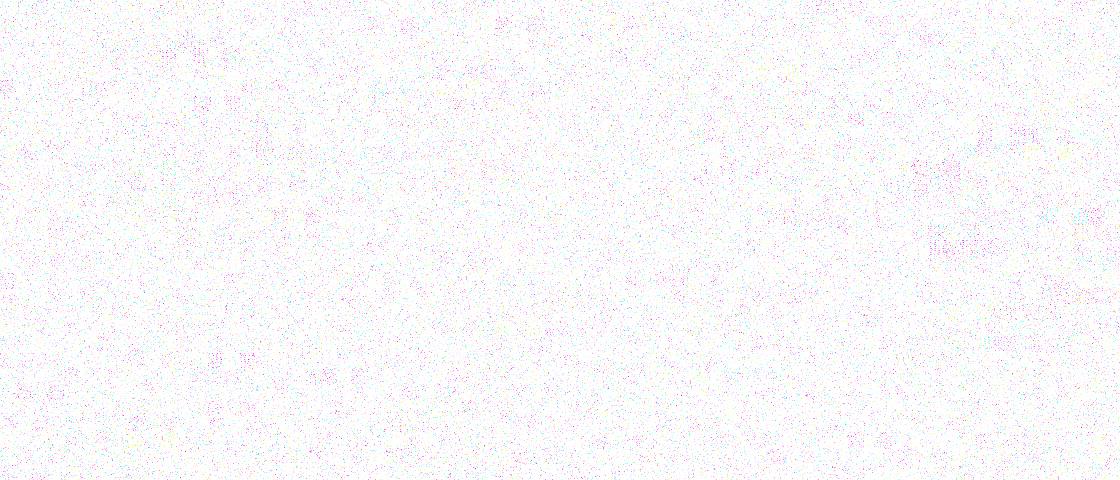

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']


['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']




In [33]:
split = AgglomerativeClustering(n_clusters=4).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [3, 4, 1, 2, 0]


<IPython.core.display.Javascript object>


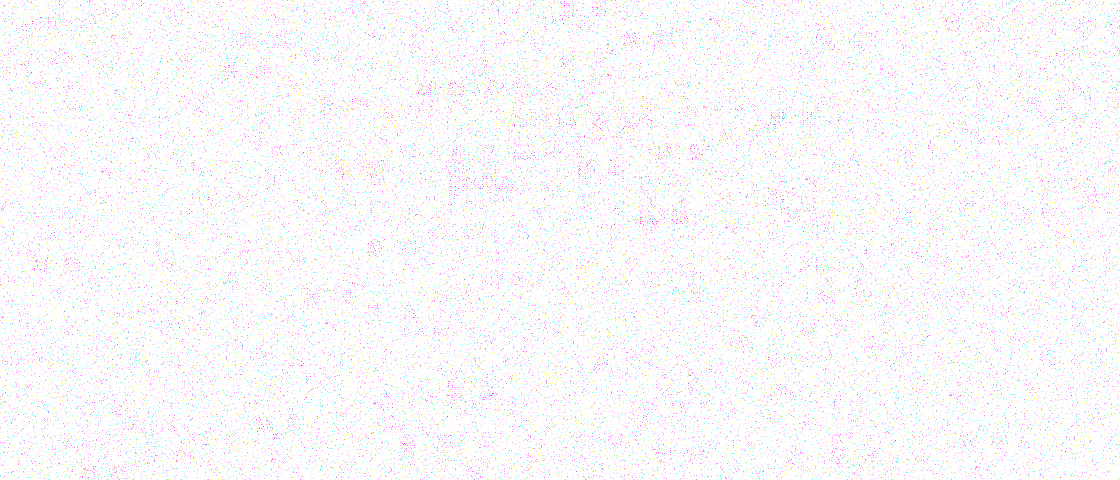

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization7_Sox10', 'Hybridization13_Plp1']




In [34]:
split = AgglomerativeClustering(n_clusters=5).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [3, 0, 2, 1, 5, 4]


<IPython.core.display.Javascript object>


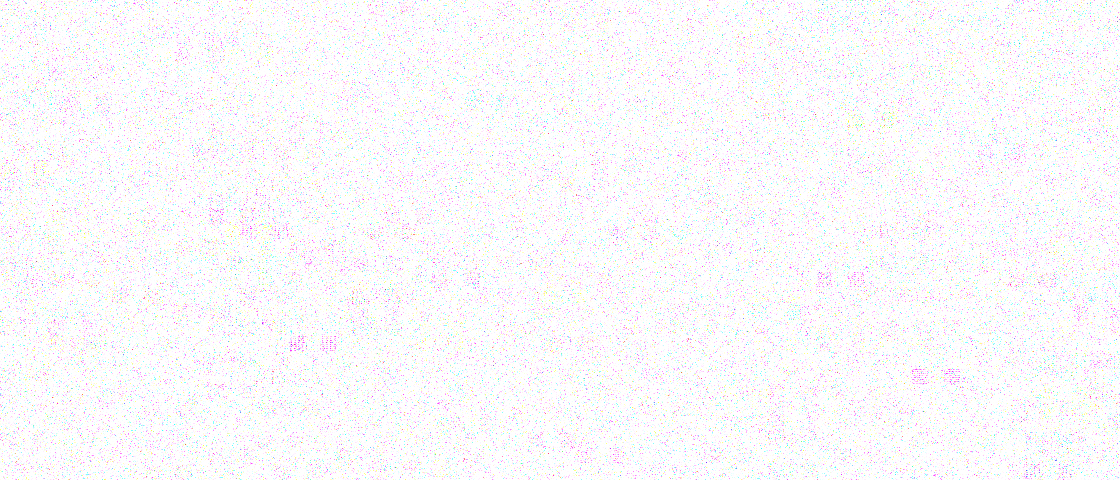

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']
0.530242270774


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']
0.422257299666


['Hybridization7_Sox10', 'Hybridization13_Plp1']
0.607426945274


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']
0.614937969074


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization7_Ctps']
0.597309059726


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']
0.542729304767




In [35]:
split = AgglomerativeClustering(n_clusters=6).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print(gini(np.array(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[0])))
    print('\n')

Order of clusters: [4, 2, 0, 5, 1, 6, 3]


<IPython.core.display.Javascript object>


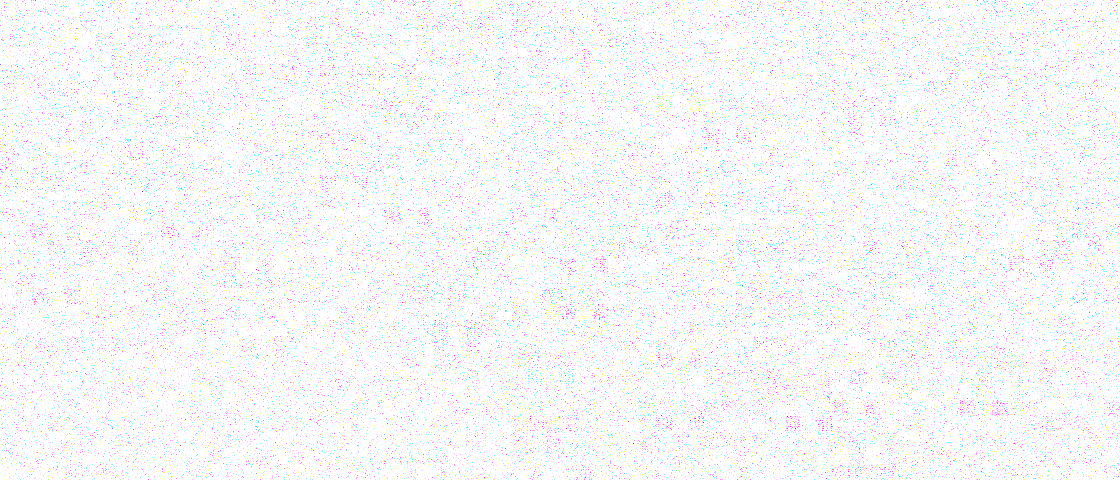

(35, 848)
848
['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']


['Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization7_Sox10', 'Hybridization13_Plp1']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization7_Ctps']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln']


['Hybridization2_Gad2', 'Hybridization6_Vip', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization9_Anln', 'Hybridization3_Mrc1', 'Hybridization5_Acta2']


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2']




In [36]:
split = AgglomerativeClustering(n_clusters=7).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.275, 80)[1])
    print('\n')

Order of clusters: [8, 10, 18, 15, 5, 12, 3, 17, 4, 7, 6, 11, 2, 0, 1, 14, 9, 19, 16, 13]


<IPython.core.display.Javascript object>


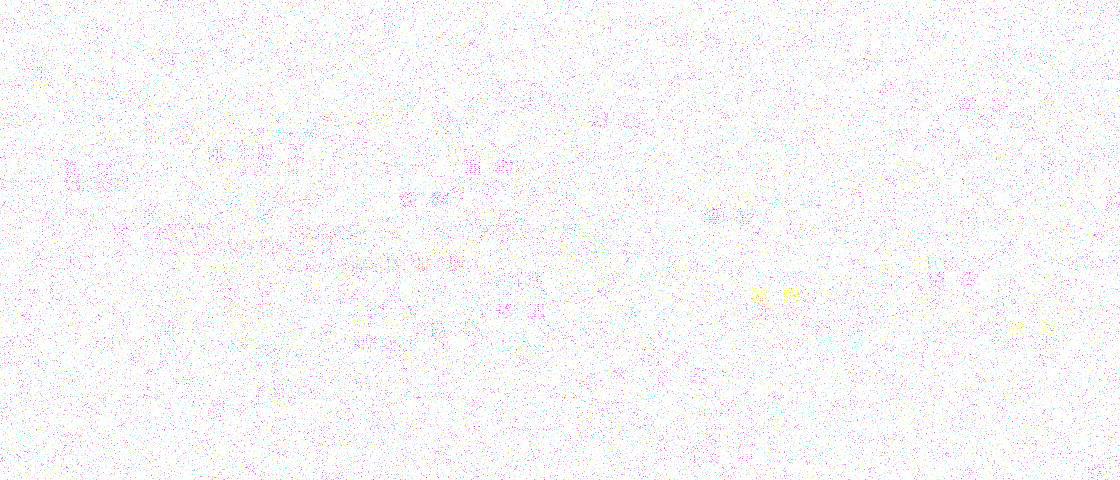

(35, 848)
848
['Hybridization2_Gad2', 'Hybridization6_Vip', 'Hybridization1_Tbr1', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization9_Anln', 'Hybridization3_Mrc1', 'Hybridization5_Acta2']
0.449219686818


['Hybridization6_Vip', 'Hybridization1_Tbr1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization7_Ctps', 'Hybridization1_Foxj1', 'Hybridization12_Vtn']
0.455205810058


['Hybridization1_Tbr1', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization9_Anln', 'Hybridization10_Apln']
0.434406437615


['Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Bmp4']
0.608578180831


['Hybridization1_Tbr1', 'Hybridization8_Serpinf1', 'Hybridization7_Sox10', 'Hybridization13_Plp1', 'Hybridization6_Itpr2', 'Hybridization11_Tmem2', 'Hybridization9_Anln']
0.510635869759


['Hybridization1_Tbr1', 'Hybridization7_Sox10']
0.659535535397


['Hybridization7_Sox10', 'Hybridization13_Plp1']
0.606648694344


['Hybridization7_Sox10', 'H

In [30]:
split = AgglomerativeClustering(n_clusters=20).fit(df_olig.T)
#cell_labels, label_cells, cellID, labels, labels_a = lb.gen_labels(df_olig, split)

cluster_order = lb.heat_map(df_olig, split.labels_)

for l in cluster_order:
    print(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[1])
    print(gini(np.array(cluster_binarity(df_olig, split.labels_, l, 0.25, 80)[0])))
    print('\n')

# Iterative clustering

In [1468]:
#Format:
#cluster_tree['LevelX_xxx'] = [[Cells], [labels], correlation, [p-values difference in expression]]
#    cells: List of all cells in this level
#    labels: Cluster labels of the cells after the split
#    correlation: Correlation coeficient r of the means of the two new clusters
#    p-values: MWU rank sum test p-values in gene expression. List of p-values for each gene compared between the two clusters.
#           None if both clusters have zeros for that gene


depth = 15
df = df_fish_size_sqrt

cluster_tree = {'Level0_' : [df.columns] } #np.zeros((1,len(df_olig.columns)))]
level_cells = {}
last_clusters = []

def MWU(df0, df1):
    pval = []
    for i in df0.index:
        if (df0.loc[i] == 0).all() and (df1.loc[i] == 0).all():
            pval.append([None, None])
        else:
            pval.append(scipy.stats.mannwhitneyu(df0.loc[i], df1.loc[i], alternative='two-sided'))
    return pval

for i in range(depth):
    for parent in [ k for k,v in cluster_tree.items() if 'Level{}'.format(i) in k]:
        #cluster parent
        cells = cluster_tree[parent][0]
        df_to_split = df.loc[:, cells]
        if df_to_split.shape[1] > 10: #Only cluster if there are more than 10 cells
            split = AgglomerativeClustering(n_clusters=2).fit(df_to_split.T)

            #Update child Level:
            #Update child cluster 0 
            code0 = 'Level{}_{}'.format(i+1, parent.split('_')[1] + '0')
            filt = split.labels_ == 0
            cluster_tree[code0] = [df_to_split.columns[filt].tolist()]
                #sub df0
            df0 = df.loc[:,cluster_tree[code0][0]]
            #Update child cluster 1
            code1 = 'Level{}_{}'.format(i+1, parent.split('_')[1] + '1')
            filt = split.labels_ == 1
            cluster_tree[code1] = [df_to_split.columns[filt].tolist()]
                #sub df1
            df1 = df.loc[:,cluster_tree[code1][0]]

            #Update parent level: 
                #Labels
            cluster_tree[parent].append(split.labels_)
                #Correlation
            cluster_tree[parent].append(np.corrcoef(df0.T.mean(), df1.T.mean())[0,1])
                #p-values for difference in expression for each gene
            cluster_tree[parent].append(MWU(df0, df1))     
        else:
            last_clusters.append(parent)
            
        
    #Sort the cells based on cluster and put them in a list
    level_cells['Level{}'.format(i)] = []
    for level in [ k for k,v in cluster_tree.items() if 'Level{}'.format(i) in k]:
        print(level)
        level_cells['Level{}'.format(i)].extend(cluster_tree[level][0])

#Complete the list of the last clusters in the splitting sequence.
for c in [i for i in cluster_tree.keys() if i.startswith('Level{}'.format(depth-1))]:
    if c not in last_clusters:
        last_clusters.append(c)

Level0_
Level1_1
Level1_0
Level2_01
Level2_10
Level2_11
Level2_00
Level3_111
Level3_000
Level3_101
Level3_110
Level3_001
Level3_010
Level3_011
Level3_100
Level4_1010
Level4_1100
Level4_0110
Level4_0101
Level4_1110
Level4_0111
Level4_1111
Level4_0010
Level4_0011
Level4_1000
Level4_1001
Level4_0100
Level4_0001
Level4_0000
Level4_1011
Level4_1101
Level5_01000
Level5_00001
Level5_00100
Level5_00111
Level5_10110
Level5_00010
Level5_10101
Level5_10000
Level5_01001
Level5_11101
Level5_11001
Level5_10001
Level5_01010
Level5_11100
Level5_00000
Level5_00101
Level5_10111
Level5_01100
Level5_00110
Level5_01011
Level5_11110
Level5_01101
Level5_01111
Level5_00011
Level5_11010
Level5_10011
Level5_11000
Level5_10010
Level5_01110
Level5_11111
Level5_10100
Level5_11011
Level6_011011
Level6_110101
Level6_000001
Level6_001000
Level6_011101
Level6_010111
Level6_010110
Level6_010100
Level6_100101
Level6_010010
Level6_100010
Level6_001100
Level6_000010
Level6_111000
Level6_010011
Level6_100111
Level6_111100


<IPython.core.display.Javascript object>


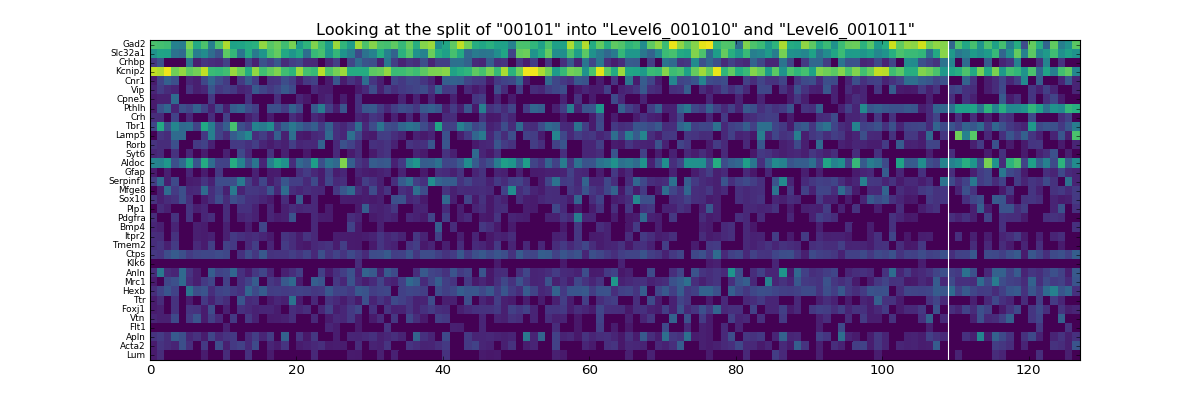

Correlation r cluster 0 & 1: 0.905016281413179
Pthlh  mean1= 0.195640882962  mean2= 0.528556466892  p= 4.50706388284e-11

Mean expression df1: 0.16427723338420858, df2: 0.17155336860076575
 MannwhitneyuResult(statistic=607.0, pvalue=0.95316679696194129)


In [1582]:
plt.figure(figsize=(15,5))

split_of_interest = '00101'

clust1 = 'Level{}_{}'.format(len(split_of_interest)+1, split_of_interest+'0')
clust2 = 'Level{}_{}'.format(len(split_of_interest)+1, split_of_interest+'1')

#Heat map
cells_of_interest = cluster_tree[clust1][0] + cluster_tree[clust2][0]

z = df.values
z = z/np.percentile(z, 99, 1)[:,None]
z = pd.DataFrame(data=z, index=df.index, columns=df.columns)
z = df.loc[:, cells_of_interest]

plt.pcolor(z, cmap='viridis', vmax=1)

plt.yticks(np.arange(0.5, len(df.index), 1), gene_sort, fontsize=8)
plt.gca().invert_yaxis()
plt.xlim(xmax=len(cells_of_interest))
plt.vlines(len(cluster_tree[clust1][0]), 0, 35, colors='w')
plt.title('Looking at the split of "{}" into "{}" and "{}"'.format(split_of_interest, clust1, clust2))

#Correlation
print('Correlation r cluster 0 & 1: {}'.format(np.corrcoef(df.loc[:,cluster_tree[clust1][0]].T.mean(), df.loc[:,cluster_tree[clust2][0]].T.mean())[0,1]))

#Differential expression
df1 = df_fish_size_sqrt.loc[:,cluster_tree[clust1][0]]
df2 = df_fish_size_sqrt.loc[:,cluster_tree[clust2][0]]

pval = []
for i in df1.index:
    test = scipy.stats.mannwhitneyu(df1.loc[i], df2.loc[i], alternative='two-sided')
    pval.append(test[1])
    p_cutoff = 0.000001
    exp_high = 0.35
    exp_low = 0.3
    #if test[1] < 0.0000001 and (df1.loc[i].mean() > 0.45 or df2.loc[i].mean() > 0.45):
    if test[1] < p_cutoff and ((df1.loc[i].mean()>exp_high and df2.loc[i].mean()<exp_low) or (df2.loc[i].mean()>exp_high and df1.loc[i].mean()<exp_low)):
        print(i.split('_')[1],' mean1=', df1.loc[i].mean(),' mean2=', df2.loc[i].mean(), ' p=', test[1])
        
#Difference in mean expression
print('\nMean expression df1: {}, df2: {}\n'.format(df1.mean(axis=1).mean(), df2.mean(axis=1).mean()),
      scipy.stats.mannwhitneyu(df1.mean(axis=1), df2.mean(axis=1), alternative='two-sided'))

In [1565]:
#Find the 

#Make a dictionary with for every last cluster a list of all the preceding clusters
branches = {}
for lc in last_clusters[:]:
    branches[lc] = []
    code_short = lc.split('_')[1]
    for n in range(len(code_short)):
        code_long = 'Level{}_{}'.format(n, code_short[:n])
        branches[lc].append(code_long)

def rule_expression(p, gene_df1, gene_df2):
    p_cutoff = 0.0000001
    exp_high = 0.45
    exp_low = 0.3
    if p == None:
        return
    if p < p_cutoff and ((gene_df1.mean()>exp_high and gene_df2.mean()<exp_low) or (gene_df2.mean()>exp_high and gene_df1.mean()<exp_low)):
        return True

    
    
#Final clusters based on differential expression
final_clusters_diffex = set([])
#Final clusters based on differential expression and expression level
final_clusters_diffex_level = set([])
#Differentially expressed genes per level
diffex_genes = {}

#Add differentially expressed genes to the 
for level_of_interest in last_clusters:
    for i, l in enumerate(branches[level_of_interest]):
        code_short = l.split('_')[1]
        next_code_0 = 'Level{}_{}'.format(len(code_short)+1, code_short+'0')
        next_code_1 = 'Level{}_{}'.format(len(code_short)+1, code_short+'1')
        df1 = df.loc[:,cluster_tree[next_code_0][0]]
        df2 = df.loc[:,cluster_tree[next_code_1][0]]

        genes = [df.index[n] for n, p in enumerate(cluster_tree[l][3]) if rule_expression(p[1], df1.loc[df.index[n]], df2.loc[df.index[n]])]
        #Add the differentially expressed genes to the level
        diffex_genes[l] = genes

#Make dictionary with differentially expressed genes for all preceding levels
branche_difex = {}
for level_of_interest in last_clusters:
    branche_difex[level_of_interest] = [diffex_genes[l] for l in branches[level_of_interest]]  

#Check if it is the last split based on the differential expression
for level_of_interest in last_clusters:
    for n, genes in enumerate(branche_difex[level_of_interest]):

        if n == len(branche_difex[level_of_interest])-1:
            print('NO END CLUSTER for brance: {}'.format(level_of_interest))
            break
            
        if n == 0 or n == 1 or n == 2:
            pass
        #Check if next level has the same genes or if it has no differentially expressed genes
        elif genes == branche_difex[level_of_interest][n+1] or genes == []:
            final_clusters_diffex.add(branches[level_of_interest][n])
            break
        
#Check if it is the last level based on the differential expression and expression level
    #for..... last_levels
    #for n, genes in enumerate(branche_difex[level_of_interest]):
    #    if n == 0:
    #        pass
    #    #Check if previous level has the same genes and  if it has no differentially expressed genes
    #    if (any(genes) in branche_difex[level_of_interest][n-1]) and branche_difex[level_of_interest][n-1] == []:
    #        final_clusters_diffex_level.add(branches[level_of_interest][n])
    #        break    
    #print(final_clusters_diffex_level)

NO END CLUSTER for brance: Level9_000110110


In [1566]:
print(len(final_clusters_diffex))
final_clusters_diffex

14


{'Level3_001',
 'Level3_010',
 'Level3_011',
 'Level3_101',
 'Level3_110',
 'Level3_111',
 'Level4_0000',
 'Level4_1000',
 'Level4_1001',
 'Level5_00010',
 'Level6_000111',
 'Level7_0001100',
 'Level8_00011010',
 'Level8_00011011'}

<IPython.core.display.Javascript object>


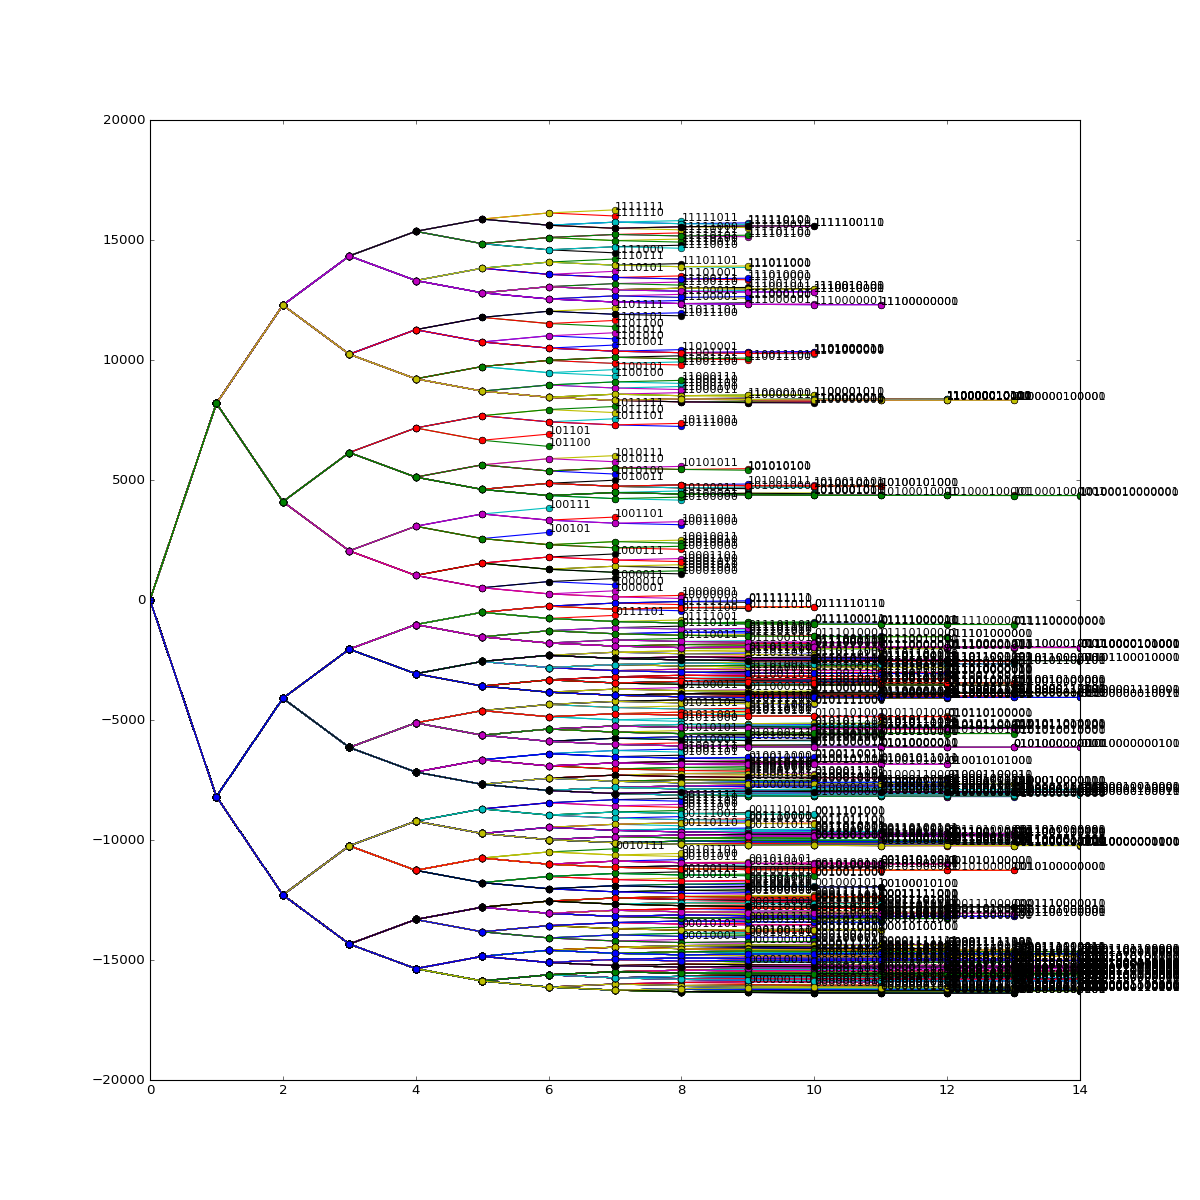

In [1400]:
#Plot the cluster tree
plt.figure(figsize=(15,15))
for l in last_clusters[:]:
    code = l.split('_')[1]
    code = [int(x) for x in list(code)]
    x = range(len(code)+1)
    
    y=[0]
    for i in range(len(code)):
        c = code[:i+1]
        steps = []
        for n, i in enumerate(c):
            max_l = 2 ** ((depth) - n)
            s = (1/4) * max_l
            if i == 0:
                steps.append(-s)
            elif i == 1:
                steps.append(s)
        y.append(sum(steps))
        
    plt.plot(x,y, marker='o')
    plt.text(x[-1], y[-1], l.split('_')[1], fontsize=10)

In [1282]:
cluster_tree['Level6_011011'][3]

[MannwhitneyuResult(statistic=1834.5, pvalue=0.6479829031799309),
 MannwhitneyuResult(statistic=1754.5, pvalue=0.93440293218426995),
 MannwhitneyuResult(statistic=1896.0, pvalue=0.29223050297037012),
 MannwhitneyuResult(statistic=975.0, pvalue=0.00021325974138366885),
 MannwhitneyuResult(statistic=1002.5, pvalue=0.00035304893953125592),
 MannwhitneyuResult(statistic=2328.0, pvalue=0.0043102888390582081),
 MannwhitneyuResult(statistic=1800.5, pvalue=0.77129355729695492),
 MannwhitneyuResult(statistic=1733.0, pvalue=0.95799389029902271),
 MannwhitneyuResult(statistic=1501.5, pvalue=0.17821718939055753),
 MannwhitneyuResult(statistic=1999.0, pvalue=0.21055994994771965),
 MannwhitneyuResult(statistic=1387.0, pvalue=0.087767537849879979),
 MannwhitneyuResult(statistic=1197.0, pvalue=0.0058161101534965533),
 MannwhitneyuResult(statistic=1125.0, pvalue=0.00022014771375386731),
 MannwhitneyuResult(statistic=1193.0, pvalue=0.0073325617739829624),
 MannwhitneyuResult(statistic=1882.5, pvalue=0.4

In [1263]:
#Logarithmic tree
#plt.figure(figsize=(15,15))
for l in last_clusters[:]:
    code = l.split('_')[1]
    code = [int(x) for x in list(code)]
    x = range(len(code)+1)
    y = [0]
    
    for i in range(len(code)):
        c = code[:i+1]
        coord = sum([(p * (2**(len(c)-(n+1)))) for n, p in enumerate(c)]) - (0.5* (2**(i+1)))
        y.append(coord)
        
    plt.plot(x,y, marker='o')
    plt.text(x[-1], y[-1], l.split('_')[1], fontsize=10)

In [1264]:
#Wrong tree
#plt.figure(figsize=(15,10))
for l in last_clusters:
    y = range(int(l.split('_')[0].split('Level')[1])) #number of splits
    code = l.split('_')[1]
    x = []
    for i in range(len(code)):
        x.append(sum([int(s)+range(len(code))[len(code)-1] for s in list(code)][:i]))
    plt.plot(x, y)
#plt.axis('equal')


<IPython.core.display.Javascript object>


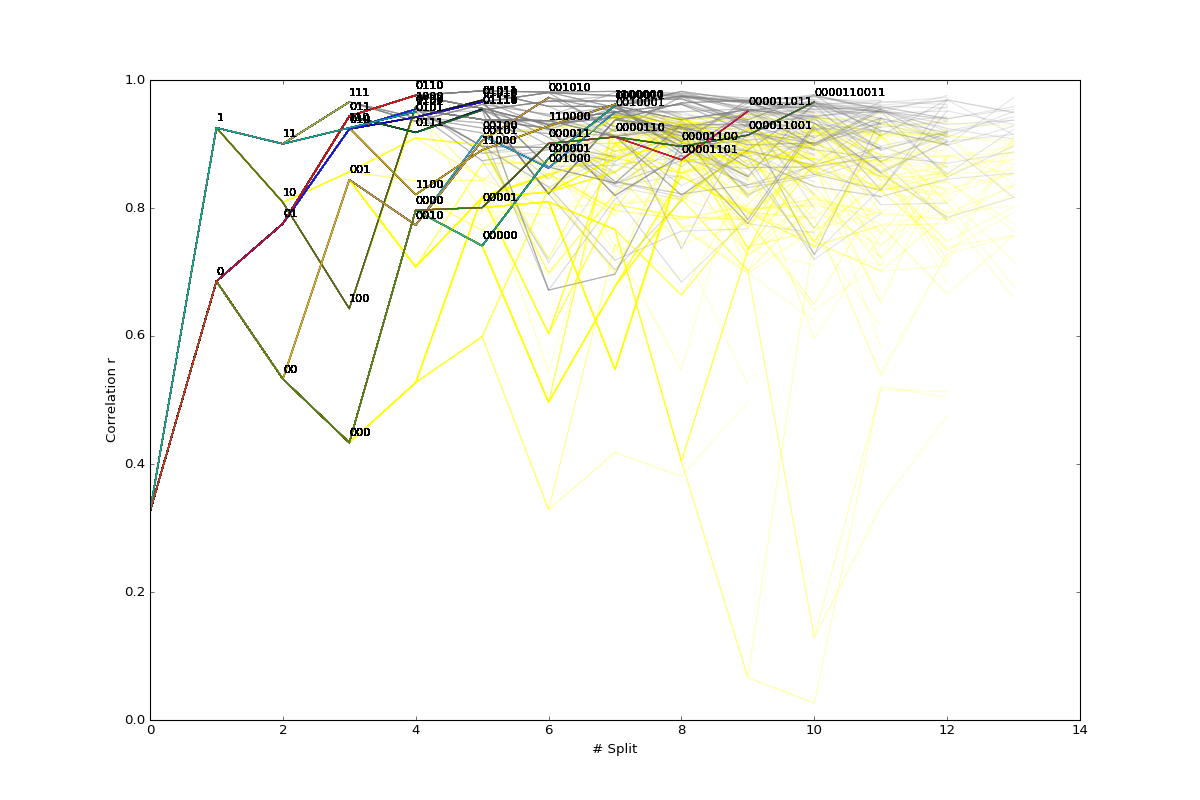

15 {'Level3_111', 'Level4_0100', 'Level5_01111', 'Level10_0000110011', 'Level5_01110', 'Level5_01011', 'Level5_01010', 'Level4_0110', 'Level9_000011011', 'Level7_0010001', 'Level4_1101', 'Level6_001010', 'Level7_0000011', 'Level7_1100000', 'Level4_1000'}


In [954]:
#Cluster evaluation based on Correlation
#Plot the correlation 

corr_clust = {}
for l in last_clusters:
    corr_clust[l] = []
    code_s = l.split('_')[1]
    for n in range(len(code_s)):
        code_l = 'Level{}_{}'.format(n, code_s[:n])
        corr_clust[l].append(cluster_tree[code_l][2])

def rule_corr(corr_list):
    for i, r in enumerate(corr_list[:-1]):
        if i == 0 or i == 1:
            pass
        else:
            #if corr_list[i-1] < r and r > .9 and corr_list[i+1] > r:
            if r > .95:
                return i  
            
final_clust = set([])
        
plt.figure(figsize=(15,10))
for i in corr_clust.keys():
    r = corr_clust[i]
    
    stop = rule_corr(r)
    if stop != None:
        terminal_cluster = 'Level{}_{}'.format(stop, i.split('_')[1][:stop])
        final_clust.add(terminal_cluster)
        plt.plot(r[:stop+1])
        for n, m in enumerate(r[:stop+1]):
            text = i.split('_')[1][:n]
            plt.text(n, m+0.01, text, fontsize=10)
        plt.plot(range(stop-1, len(r)), r[stop-1:], alpha=0.1, c='grey')
    else:
        plt.plot(r, c='yellow', alpha=0.1, linewidth=1)

plt.ylabel('Correlation r')
plt.xlabel('# Split')
        
print(len(final_clust) ,final_clust)
    

In [ ]:
def iterative_clustering(df):
    #Make the label table
    initial_labels = np.array(['L0_C0' for i in range(len(df_fish.columns))]).reshape((1,len(df_fish.columns)))
    label_tree = pd.DataFrame(data=initial_labels, columns=df.columns)
    
    current_level = 0
    offset = 0
    
    #Iterate through the current sub clusters
    for superclust in np.unique(label_tree.loc[current_level]):
        current_level += 1
        print(superclust)
        filt = label_tree.loc[current_level] == superclust
        df_to_clust = df.loc[:,filt]
        
        #Split cells into two clusters
        split = AgglomerativeClustering(n_clusters=2).fit(df_to_clust.T)
        
        #Update the label_tree with new temporary labels (Format: Level X _ Cluster Y --> LxCy)
        for i, cell in enumerate(df_to_clust.columns):
            cluster_id = 'L{}_C{}'.format((current_level), (split.labels_[i]+offset))
            label_tree.loc[current_level, cell] = cluster_id